# **Workout Analysis – Data Science Project**  
Machine learning on workout logs to model fitness performance.  
- Phase 1: Calories burned prediction (XGBoost, R² ≈ 0.41, insights on pace & duration).  
- Phase 2: Strength performance analysis (feature importance reveals weekly workload is most predictive).

This project demonstrates **end-to-end ML pipelines, feature engineering, and insight extraction** from noisy real-world data. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel("workout_log.xlsx")
df.head()

,date,body_part,exercise,set_no,weight_kg,reps,volume_kg,notes
0,2023-10-06,Shoulder,Shoulder press,1,10,20.0,200.0,NaN
1,2023-10-06,Shoulder,Face pulls,3,35,10.0,350.0,NaN
2,2023-10-06,Shoulder,Face pulls,2,30,12.0,360.0,NaN
3,2023-10-06,Shoulder,Face pulls,1,25,15.0,375.0,NaN
4,2023-10-06,Shoulder,Dumbbell lat raises,2,7.5,15.0,112.5,NaN


In [3]:
df.shape

(5993, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5993 non-null   datetime64[ns]
 1   body_part  5993 non-null   object        
 2   exercise   5993 non-null   object        
 3   set_no     5993 non-null   int64         
 4   weight_kg  5739 non-null   object        
 5   reps       5739 non-null   float64       
 6   volume_kg  5415 non-null   float64       
 7   notes      255 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 374.7+ KB


#### Since some of the exercise's are body weight we use body weight percentages for those exercises to map them and fill out their respective volume

In [5]:
bodyweight = 56  # or a column if you want it to vary over time

bw_percentages = {
    "pull up": 1.0,
    "push up": 0.65,
    "dip": 0.95,
    "plank": 0.7,
    "back extension": 1.0,
    "hip flexion": 1.0,
    "hanging leg raise": 1.0,
    "hanging knee raise": 0.40
}

def replace_bw(row):
    if isinstance(row['weight_kg'], str) and row['weight_kg'].lower() == "bw":
        for ex, pct in bw_percentages.items():
            if ex in row['exercise'].lower():
                return bodyweight * pct
        return bodyweight  # fallback if no mapping found
    return row['weight_kg']

df['weight_kg'] = df.apply(replace_bw, axis=1)

In [6]:
df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors='coerce')
df['reps'] = pd.to_numeric(df['reps'], errors='coerce')

In [7]:
df['volume_kg'] = df['weight_kg'] * df['reps']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5993 non-null   datetime64[ns]
 1   body_part  5993 non-null   object        
 2   exercise   5993 non-null   object        
 3   set_no     5993 non-null   int64         
 4   weight_kg  5739 non-null   float64       
 5   reps       5739 non-null   float64       
 6   volume_kg  5739 non-null   float64       
 7   notes      255 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 374.7+ KB


In [9]:
df_copy = df.copy()

In [10]:
df_copy.head()

,date,body_part,exercise,set_no,weight_kg,reps,volume_kg,notes
0,2023-10-06,Shoulder,Shoulder press,1,10.0,20.0,200.0,NaN
1,2023-10-06,Shoulder,Face pulls,3,35.0,10.0,350.0,NaN
2,2023-10-06,Shoulder,Face pulls,2,30.0,12.0,360.0,NaN
3,2023-10-06,Shoulder,Face pulls,1,25.0,15.0,375.0,NaN
4,2023-10-06,Shoulder,Dumbbell lat raises,2,7.5,15.0,112.5,NaN


#### In order to form `df_cardio` we need to extract information like calories, distance and time from the raw, scrappy notes. We use regular expression (re) to tackle different types of text permutations of the notes so that regardless of how the notes are written we can still extract the relevant features

In [11]:
mask_cardio = df_copy['notes'].str.contains(r'cal|dist|min', case=False, na=False)
df_cardio = df_copy[mask_cardio].copy()
df_strength = df_copy[~mask_cardio].copy()

In [12]:
def parse_cardio_note_disambiguate(note):
    """
    Returns pd.Series([duration_min, calories, distance_km]) parsed from free-text `note`.
    Designed to handle multiple formats robustly.
    """
    if pd.isna(note):
        return pd.Series([None, None, None])

    s = str(note).lower()
    s = s.replace(';', ' ').replace(',', ' ')

    # --- Duration: sum mm:ss, "min: N", and "N min" ---
    duration = 0.0
    found = False

    # mm:ss
    mmss = re.findall(r'(\d+):(\d+)\s*min', s)
    for hh, mm in mmss:
        duration += int(hh) + int(mm) / 60.0
        found = True
    s_after_mmss = re.sub(r'\d+:\d+\s*min', ' ', s)

    # "min: N" or "mins: N" (number after label)
    min_after = re.findall(r'(?:min|mins)\s*[:\-]\s*([0-9]+(?:\.[0-9]+)?)', s_after_mmss)
    for m in min_after:
        try:
            duration += float(m)
            found = True
        except:
            pass
    s_after_min_after = re.sub(r'(?:min|mins)\s*[:\-]\s*[0-9]+(?:\.[0-9]+)?', ' ', s_after_mmss)

    # "N min" (number before label) from remaining text
    min_before = re.findall(r'([0-9]+(?:\.[0-9]+)?)\s*min', s_after_min_after)
    for m in min_before:
        try:
            duration += float(m)
            found = True
        except:
            pass
    duration_val = duration if found else None

    # --- Calories: prefer "cal: N" (strict) else "N cal" ---
    calories = None
    cal_after_strict = re.search(r'cal(?:ories)?\s*[:\-]\s*([0-9]+(?:\.[0-9]+)?)', s)
    if cal_after_strict:
        calories = float(cal_after_strict.group(1))
    else:
        cal_before = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*cal(?:ories)?', s)
        if cal_before:
            calories = float(cal_before.group(1))

    # --- Distance: handle 'dist N', 'N dist', 'N km' and disambiguate if both forms appear ---
    distance = None
    dist_after = re.search(r'dist(?:ance)?\s*[:\-]?\s*([0-9]+(?:\.[0-9]+)?)', s)
    dist_before = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:dist|distance)\b', s)
    dist_km = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(km|kilometre|kilometers|miles?)', s)

    if dist_after and dist_before:
        a = float(dist_after.group(1))
        b = float(dist_before.group(1))
        # heuristic: prefer decimal or small numbers as distance (typical for km)
        if ('.' in dist_before.group(1)) or (b < 15 and a > 15):
            distance = b
        else:
            distance = a
    elif dist_after:
        distance = float(dist_after.group(1))
    elif dist_before:
        distance = float(dist_before.group(1))
    elif dist_km:
        distance = float(dist_km.group(1))
        if dist_km.group(2).startswith('mile'):
            distance *= 1.60934

    return pd.Series([duration_val, calories, distance])


In [13]:
# parse and write back into df_cardio
df_cardio[['duration_min','calories','distance_km']] = df_cardio['notes'].apply(parse_cardio_note_disambiguate)

# convert types
df_cardio['duration_min'] = pd.to_numeric(df_cardio['duration_min'], errors='coerce')
df_cardio['calories'] = pd.to_numeric(df_cardio['calories'], errors='coerce')
df_cardio['distance_km'] = pd.to_numeric(df_cardio['distance_km'], errors='coerce')

In [14]:
# dropping irrelevant columns
df_cardio.drop(['weight_kg','reps','volume_kg'],axis=1, inplace=True)

In [15]:
df_cardio.head()

,date,body_part,exercise,set_no,notes,duration_min,calories,distance_km
1976,2024-05-04,Cardio,Trademill,1,12 mins dist:1.22 cal: 90,12.0,90.0,1.22
1977,2024-05-04,Cardio,Cycle,1,10 mins dist:2.5 cal 43,10.0,2.5,2.50
2049,2024-05-11,Cardio,Cycle,1,10 min 47 cal dist - 2.6,10.0,47.0,2.60
2050,2024-05-11,Cardio,Trademill,1,12 min 91 cal dist-1.26,12.0,91.0,1.26
2096,2024-05-18,Cardio,Trademill,1,12 min 98 cal dist: 1.38,12.0,98.0,1.38


In [16]:
df_cardio.isna().sum()

date              0
body_part         0
exercise          0
set_no            0
notes             0
duration_min    146
calories        156
distance_km     155
dtype: int64

In [17]:
df_strength.drop('notes',axis=1, inplace=True)

In [18]:
df_strength.isna().sum()

date          0
body_part     0
exercise      0
set_no        0
weight_kg    10
reps         10
volume_kg    10
dtype: int64

In [19]:
df_strength.to_csv("strength_logs.csv", index=False)
df_cardio.to_csv("cardio_logs.csv", index=False)

In [20]:
# Combine dates from strength and cardio
all_dates = pd.concat([df_strength['date'], df_cardio['date']])

# Count how many workouts per day
training_days = all_dates.value_counts().sort_index()

# DataFrame with daily counts
df_consistency = pd.DataFrame({
    'date': training_days.index,
    'workouts': training_days.values
})
df_consistency['date'] = pd.to_datetime(df_consistency['date'])
df_consistency = df_consistency.set_index('date')

# Daily frequency (fill 0 for missing days)
df_daily = df_consistency.resample('D').sum().fillna(0)

# Extract week & weekday using isocalendar
df_daily['week'] = df_daily.index.isocalendar().week
df_daily['year'] = df_daily.index.isocalendar().year
df_daily['day'] = df_daily.index.weekday  # Monday=0, Sunday=6

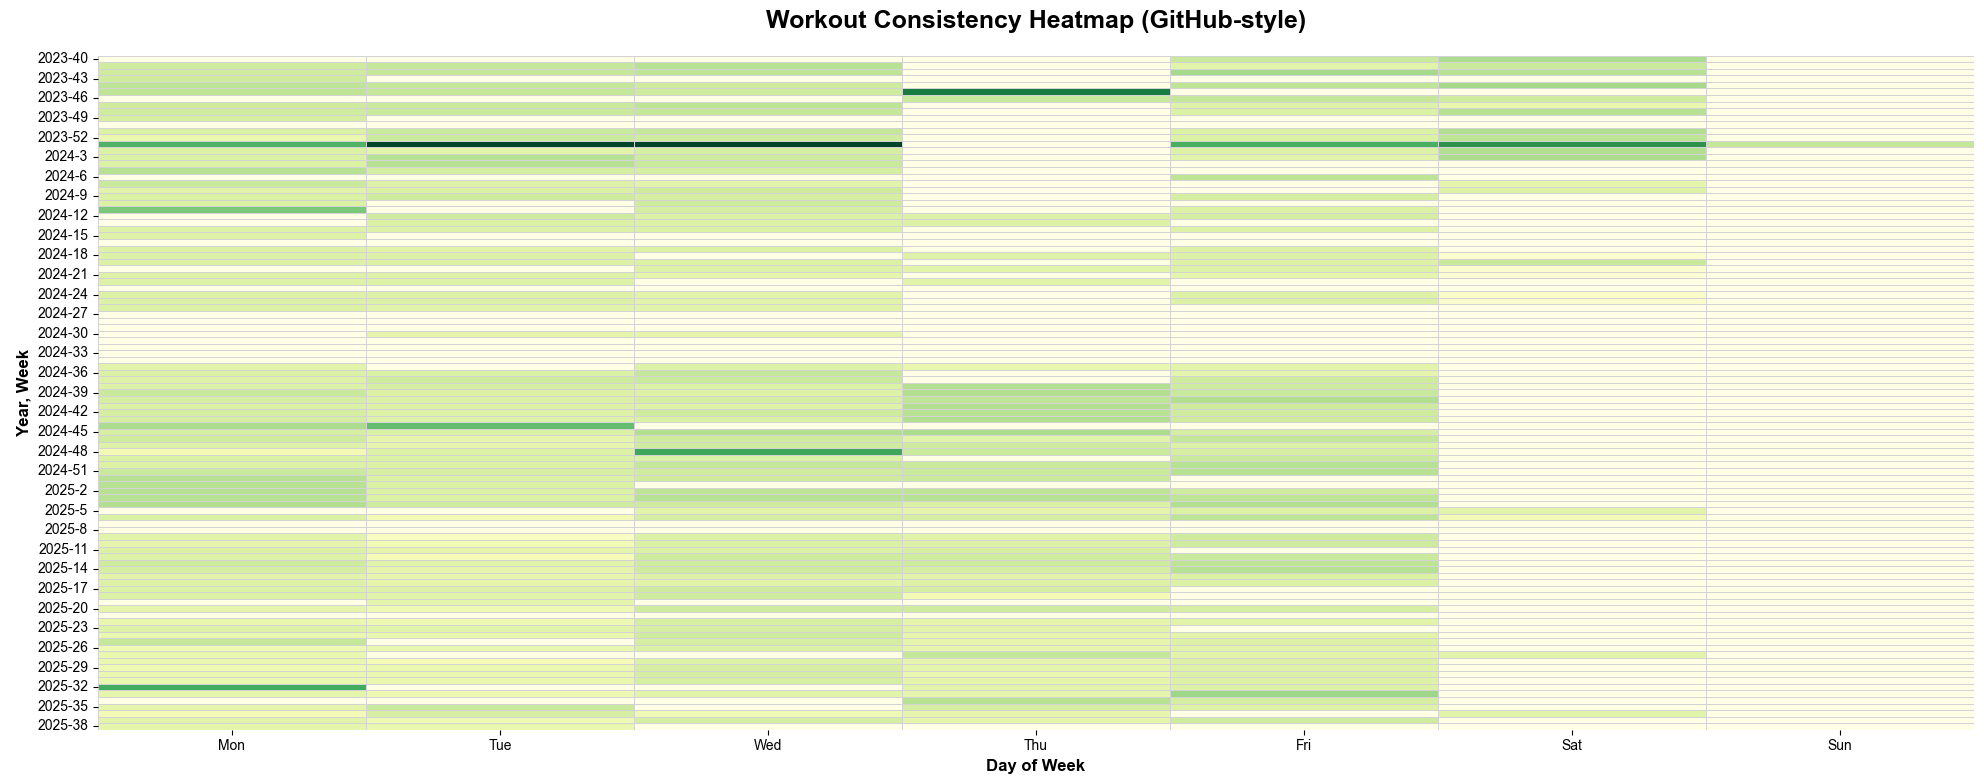

In [21]:
pivot = df_daily.pivot_table(
    values='workouts',
    index=['year','week'],
    columns='day',
    fill_value=0
)
plt.figure(figsize=(20,8))
sns.heatmap(
    pivot,
    cmap="YlGn",            
    cbar=False,             
    linewidths=0.5,
    linecolor="lightgrey",
    square=False
)

plt.title("Workout Consistency Heatmap (GitHub-style)", fontsize=18, weight="bold", pad=20)
plt.xlabel("Day of Week", fontsize=12, weight="bold")
plt.ylabel("Year, Week", fontsize=12, weight="bold")

# Replace 0–6 with weekday names
plt.xticks(
    ticks=[i + 0.5 for i in range(7)],
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0
)

sns.set_theme(style="white")
plt.gca().set_facecolor("white")

plt.tight_layout()
plt.show()


#### The graph above represents the total workout consistency where X-axis represent days of the week, Y-axis represent year-week i.e each row demonstrates one calender week and the color represent intensity i.e as the color gets darker more then 1 workout (strength + cardio) was recorded 

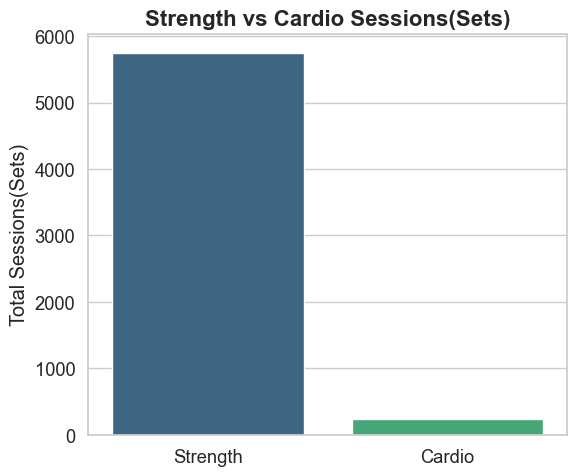

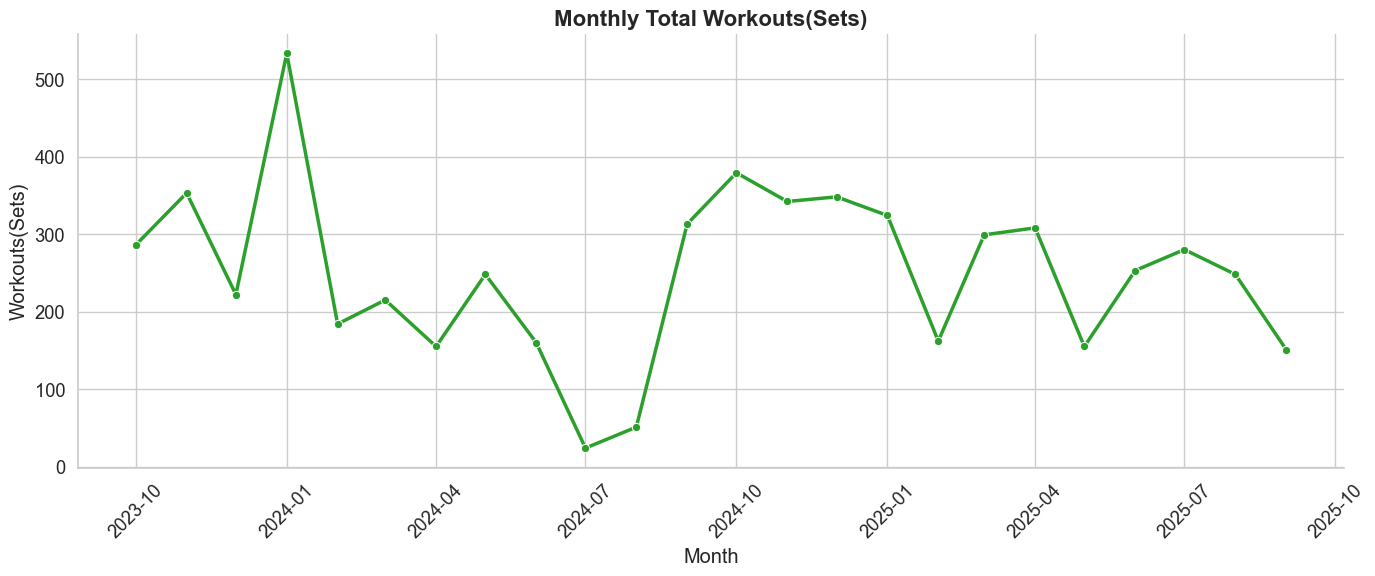

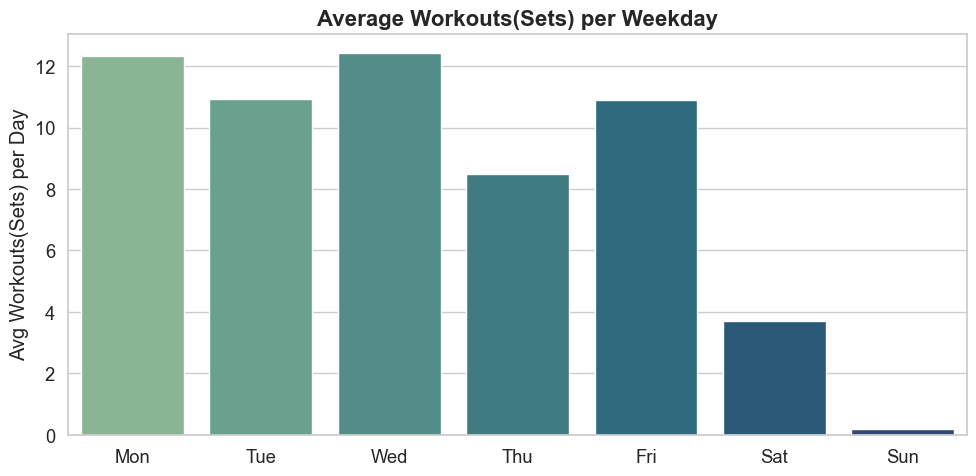

In [22]:
sns.set_theme(style="whitegrid", font_scale=1.2)

# -----------------------------
# 1. Strength vs Cardio Breakdown
# -----------------------------
workout_type_counts = pd.DataFrame({
    "Strength": [df_strength['date'].count()],
    "Cardio": [df_cardio['date'].count()]
}).melt(var_name="Workout Type", value_name="Sessions")

plt.figure(figsize=(6,5))
sns.barplot(data=workout_type_counts, x="Workout Type", y="Sessions", hue="Workout Type", palette="viridis")
plt.title("Strength vs Cardio Sessions(Sets)", fontsize=16, weight="bold")
plt.ylabel("Total Sessions(Sets)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Monthly Trends
# -----------------------------
df_daily['month'] = df_daily.index.to_period('M')
monthly_trend = df_daily.groupby('month')['workouts'].sum().reset_index()
monthly_trend['month'] = monthly_trend['month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_trend, x="month", y="workouts", marker="o", linewidth=2.5, color="#2ca02c")
plt.title("Monthly Total Workouts(Sets)", fontsize=16, weight="bold")
plt.ylabel("Workouts(Sets)")
plt.xlabel("Month")
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Weekly Patterns (Weekday Avg)
# -----------------------------
weekday_avg = df_daily.groupby('day')['workouts'].mean().reset_index()
weekday_avg['day'] = weekday_avg['day'].map({
    0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"
})

plt.figure(figsize=(10,5))
sns.barplot(data=weekday_avg, x="day", y="workouts", hue="day", palette="crest")
plt.title("Average Workouts(Sets) per Weekday", fontsize=16, weight="bold")
plt.ylabel("Avg Workouts(Sets) per Day")
plt.xlabel("")
plt.tight_layout()
plt.show()


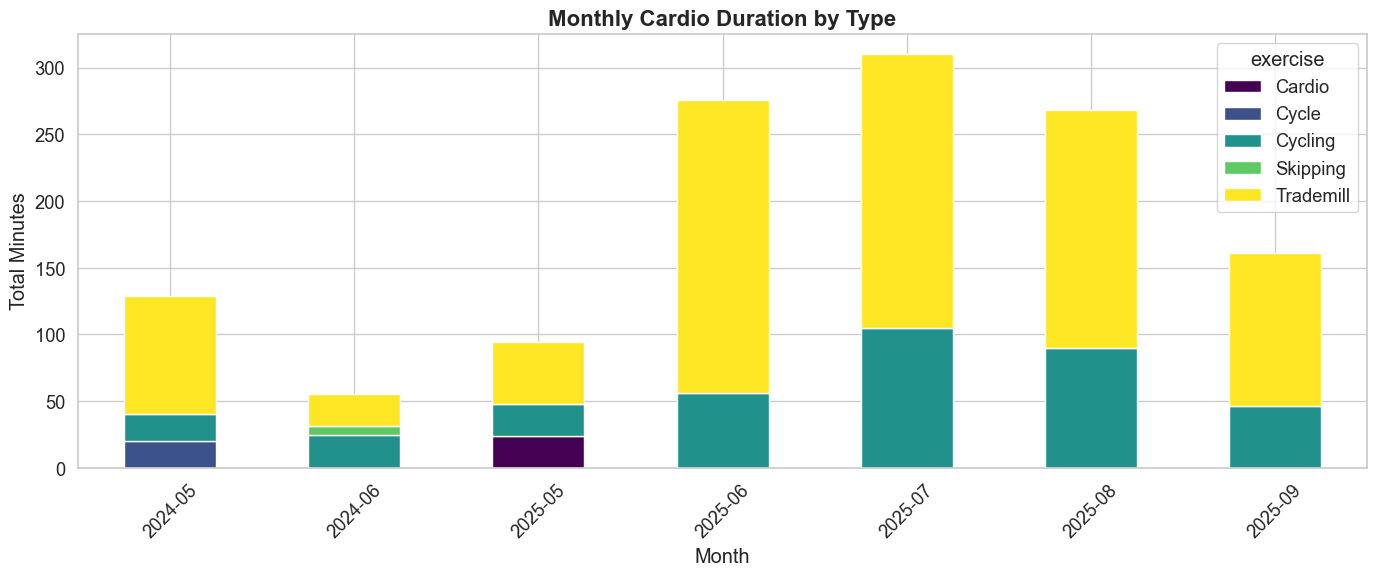

In [23]:
df_cardio['date'] = pd.to_datetime(df_cardio['date'])
df_cardio['month'] = df_cardio['date'].dt.to_period('M')

monthly_cardio_type = df_cardio.groupby(
    [df_cardio['month'], 'exercise']
)['duration_min'].sum().unstack(fill_value=0)

monthly_cardio_type.plot(
    kind='bar', stacked=True, figsize=(14,6), colormap="viridis"
)
plt.title("Monthly Cardio Duration by Type", fontsize=16, weight="bold")
plt.ylabel("Total Minutes")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

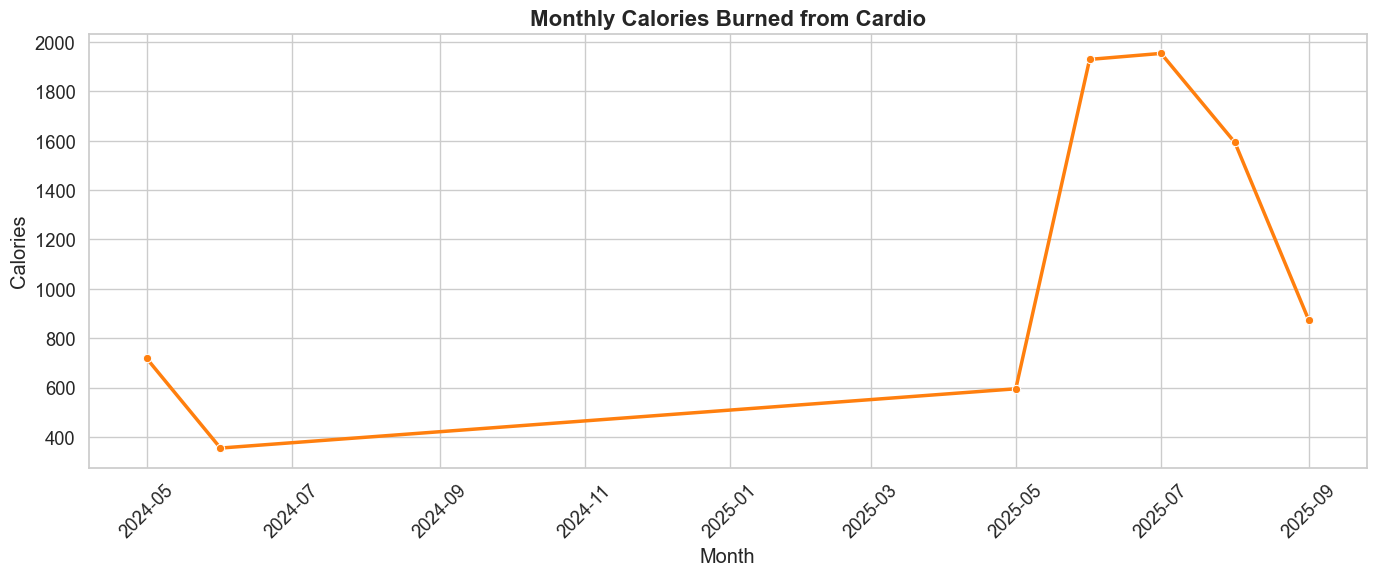

In [24]:
monthly_calories = df_cardio.groupby('month')['calories'].sum().reset_index()
monthly_calories['month'] = monthly_calories['month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.lineplot(
    data=monthly_calories, x="month", y="calories", marker="o",
    color="#ff7f0e", linewidth=2.5
)
plt.title("Monthly Calories Burned from Cardio", fontsize=16, weight="bold")
plt.ylabel("Calories")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Phase 1 – Calories Burned Prediction

#### 1. Introduction
Problem statement:
1. “Can we predict calories burned in a cardio session using workout metrics (duration, distance, exercise type, seasonality)?”
2. Why it matters: calorie tracking, fitness optimization, personalized training plans.
3. Data: collected cardio logs (244 entries, with missing calories in 64%).

#### 2. Data Preparation 

1. Overview of columns `(date, exercise, duration, distance, calories, month)`.
2. Data cleaning:
    1. Dropped redundant columns `(body_part, notes)`.
    2. Normalized exercise values `(cycle → cycling, etc.)`.
    3. Removed sparse entries `(skipping)`.
3. Missing values:
    1. Median imputation for `distance_km` and `duration_min` per exercise.
    2. Baseline linear regression used to impute missing `calories `(64% rows).
    3. Added `calories_imputed` flag for traceability.

In [25]:
df_cardio.isna().sum()

date              0
body_part         0
exercise          0
set_no            0
notes             0
duration_min    146
calories        156
distance_km     155
month             0
dtype: int64

In [26]:
df_cardio.drop(columns=["body_part","notes"],axis=1,inplace=True)

In [27]:
exercise_map = {
    "cycle": "cycling",
    "cycling": "cycling",
    "trademill": "treadmill",
    "cardio": "treadmill"
}
df_cardio["exercise"] = df_cardio["exercise"].str.lower().map(exercise_map).fillna(df_cardio["exercise"].str.lower())
df_cardio = df_cardio[df_cardio['exercise'] != 'skipping']

In [28]:
# Impute distance/duration if missing
df_cardio["distance_km"] = df_cardio.groupby("exercise")["distance_km"].transform(
    lambda x: x.fillna(x.median())
)
df_cardio["duration_min"] = df_cardio.groupby("exercise")["duration_min"].transform(
    lambda x: x.fillna(x.median())
)

In [29]:
df_cardio.isna().sum()

date              0
exercise          0
set_no            0
duration_min      0
calories        151
distance_km       0
month             0
dtype: int64

#### Since 151 out of 244 which is almost 61% of total entries have missing calorie value which is also the target variable y, it is not a good practice to drop so many null values. So we impute those by training a model on the existing non-null entires

In [30]:
# Step 0: Split complete vs incomplete rows
complete = df_cardio.dropna(subset=["calories"]).copy()
incomplete = df_cardio[df_cardio["calories"].isna()].copy()

# Step 1: Train a baseline model on complete data
X = complete[["duration_min", "distance_km"]] 
y = complete["calories"]

model = LinearRegression().fit(X, y)

# Step 2: Predict calories for missing rows
incomplete["calories"] = model.predict(incomplete[["duration_min", "distance_km"]])

# Step 3: Concatenate back
df_cardio = pd.concat([complete, incomplete], ignore_index=True)
df_cardio["calories_imputed"] = df_cardio.index.isin(incomplete.index)

#### 3. Feature Engineering
1. Pace = distance ÷ duration.
2. Cyclical encoding for month `(sin_month, cos_month)`.
3. One-hot encoding for exercise.
4. Final feature set = `[duration_min, distance_km, pace, sin_month, cos_month, exercise_*]`.

In [31]:
df_cardio["pace"] = df_cardio["distance_km"] / df_cardio["duration_min"].replace(0, np.nan)

In [32]:
# Extract month number (1–12)
df_cardio["month_num"] = df_cardio["month"].dt.month

# Cyclical encoding
df_cardio["sin_month"] = np.sin(2 * np.pi * df_cardio["month_num"] / 12)
df_cardio["cos_month"] = np.cos(2 * np.pi * df_cardio["month_num"] / 12)

#### 4. Modeling 
1. Train/test split (80/20).
2. Preprocessing pipeline:
    1. Scale numeric features.
    2. One-hot encode categorical.
3. Models tested:
    1. Linear Regression (baseline)
    2. Random Forest Regressor
    3. XGBoost Regressor

In [33]:
X = df_cardio[["duration_min", "distance_km", "pace", "exercise", "sin_month", "cos_month"]]
y = df_cardio["calories"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ["duration_min", "distance_km", "pace", "sin_month", "cos_month"]
cat_features = ["exercise"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [34]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 9.948556806707908
RMSE: 529.2502590505368
R2: -2.2719800432011943


In [35]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- Random Forest ---
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,   
        max_depth=None,     
        random_state=42,
        n_jobs=-1           
    ))
])

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\n--- Random Forest ---")
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", mean_squared_error(y_test, rf_preds))
print("R2:", r2_score(y_test, rf_preds))

# --- XGBoost ---
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("\n--- XGBoost ---")
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("RMSE:", mean_squared_error(y_test, xgb_preds))
print("R2:", r2_score(y_test, xgb_preds))



--- Random Forest ---
MAE: 7.074088734190522
RMSE: 96.41184862203887
R2: 0.40395372656903406

--- XGBoost ---
MAE: 6.607340845973102
RMSE: 95.29870593197917
R2: 0.41083550055936646


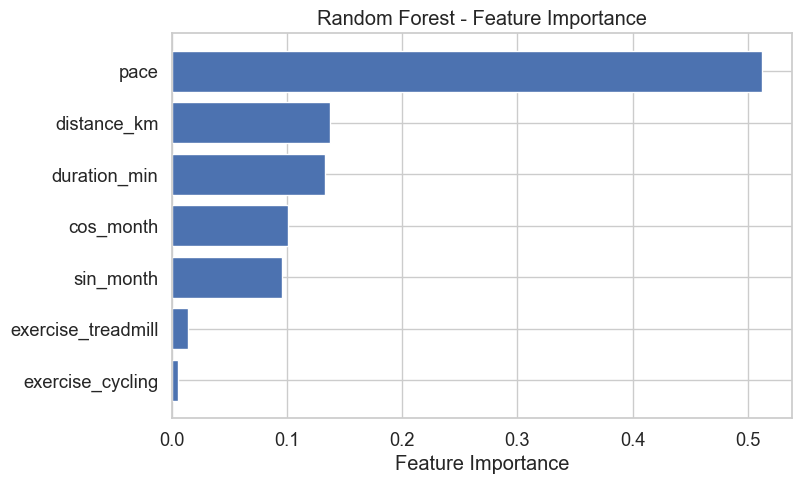

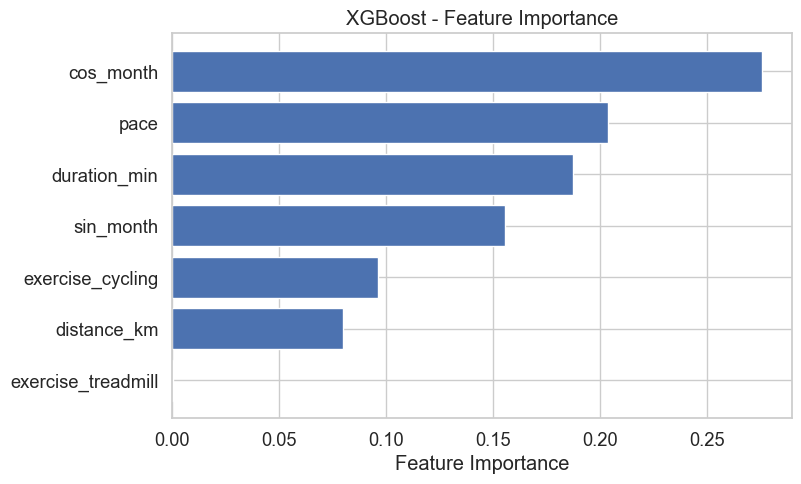

In [36]:
# --- Get feature names after preprocessing ---
# Numerical + encoded categorical
ohe = preprocessor.named_transformers_["cat"]
ohe_features = list(ohe.get_feature_names_out(cat_features))
feature_names = num_features + ohe_features

# --- Random Forest Importance ---
rf_importances = rf_model.named_steps["regressor"].feature_importances_

# Plot RF importances
plt.figure(figsize=(8, 5))
indices = np.argsort(rf_importances)[::-1]
plt.barh([feature_names[i] for i in indices], rf_importances[indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# --- XGBoost Importance ---
xgb_importances = xgb_model.named_steps["regressor"].feature_importances_

plt.figure(figsize=(8, 5))
indices = np.argsort(xgb_importances)[::-1]
plt.barh([feature_names[i] for i in indices], xgb_importances[indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost - Feature Importance")
plt.gca().invert_yaxis()
plt.show()


#### 6. Feature Importance & Interpretation
1. Random Forest: pace dominated.
2. XGBoost: cos_month + pace + duration were top.

#### 7. Insights:

1. **Workout intensity drives calorie burn**:
    1. The engineered feature **pace (distance ÷ duration)** was the strongest predictor across both Random Forest and XGBoost.
    2. This confirms that calorie expenditure is more strongly linked to **how hard you go**, not just how long you exercise.
2. **Workout duration still matters:**
    1. Longer sessions consistently contributed to higher predicted calorie burn.
    2. Distance on its own was less important once pace and duration were included.
3. **Seasonality plays a role**:
    1. Cyclical month features (`sin_month, cos_month`) ranked surprisingly high in XGBoost, suggesting seasonal patterns in training (e.g., more treadmill in monsoon, outdoor cycling in summer).
4. **Exercise type mattered less than expected:**
    1. Once pace and duration were included, the difference between cycling vs treadmill contributed minimally.
    2. This suggests the intensity of effort matters more than the machine used.

#### 7. Conclusion:
1. The models achieved moderate predictive accuracy (best R² ≈ 0.41 with XGBoost).
2. While not perfect, the analysis provided clear, interpretable insights:
    1. Intensity (pace) is the primary driver of calorie burn.
    2. Duration and seasonality also play meaningful roles.
    3. Exercise choice (cycling vs treadmill) has little effect once effort is accounted for.

--------------------------------------------------------------------------------------------------------------------------

### Phase 2: Strength Performance Prediction

#### 1. Introduction

1. Problem statement: “Can we predict next-day strength performance (measured as total training volume lifted) using historical strength training data?”
2. Why it matters:
    1. Helps in workload management and avoiding overtraining.
    2. Provides actionable insights on how yesterday’s effort and recent training consistency affect tomorrow’s performance.
    3. Shows how ML can model temporal patterns in fitness data.
3. Data:
    1. ~5.7k strength records aggregated into daily training volumes.
    2. Covers multiple months of training logs.

#### 2. Feature Engineering:

1. `strength_lag1` = yesterday’s training volume.
2. `strength_rolling7` = 7-day moving average (captures short-term fatigue & consistency).
3. `strength_rolling30` = 30-day moving average (captures long-term adaptation trend).
4. Target variable: `y_strength_nextday` = total strength volume for the next day.
5. Final feature set: `[strength_lag1, strength_rolling7, strength_rolling30]`.

In [37]:
df_strength_daily = (
    df_strength.groupby("date")["volume_kg"]
    .sum()
    .reset_index()
    .rename(columns={"volume_kg": "total_strength_volume"})
)

In [38]:
df_strength_daily = df_strength_daily.sort_values("date").reset_index(drop=True)

# Yesterday’s volume
df_strength_daily["strength_lag1"] = df_strength_daily["total_strength_volume"].shift(1)

# 7-day rolling average (trend / load management)
df_strength_daily["strength_rolling7"] = df_strength_daily["total_strength_volume"].rolling(7).mean()

# 30-day rolling average (longer-term adaptation)
df_strength_daily["strength_rolling30"] = df_strength_daily["total_strength_volume"].rolling(30).mean()

In [39]:
df_strength_daily["y_strength_nextday"] = df_strength_daily["total_strength_volume"].shift(-1)

In [40]:
df_strength_daily = df_strength_daily.dropna().reset_index(drop=True)

In [41]:
df_strength_daily.head()

,date,total_strength_volume,strength_lag1,strength_rolling7,strength_rolling30,y_strength_nextday
0,2023-11-25,2845.0,3795.0,3589.928571,4249.833333,3841.0
1,2023-11-27,3841.0,2845.0,3717.500000,4276.200000,4402.5
2,2023-11-28,4402.5,3841.0,3822.285714,4270.050000,3085.0
3,2023-11-29,3085.0,4402.5,3692.285714,4259.883333,3702.5
4,2023-12-01,3702.5,3085.0,3561.928571,4261.966667,3835.0


In [42]:
df_strength_daily.shape

(342, 6)

#### 4. Modeling:

1. Train/test split: 80% train, 20% test (time-based split, no shuffling).
2. Preprocessing pipeline: Standardize numeric features.
3. Models tested:
    1. Linear Regression (baseline).
    2. Random Forest Regressor.
    3. XGBoost Regressor.

In [43]:
X = df_strength_daily[["strength_lag1", "strength_rolling7", "strength_rolling30"]]
y = df_strength_daily["y_strength_nextday"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), X.columns)
])

In [44]:
# --- Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}



--- Linear Regression Results: ---
MAE: 1039.6331108518796
RMSE: 1635144.5673334063
R2: -0.23289401302008983


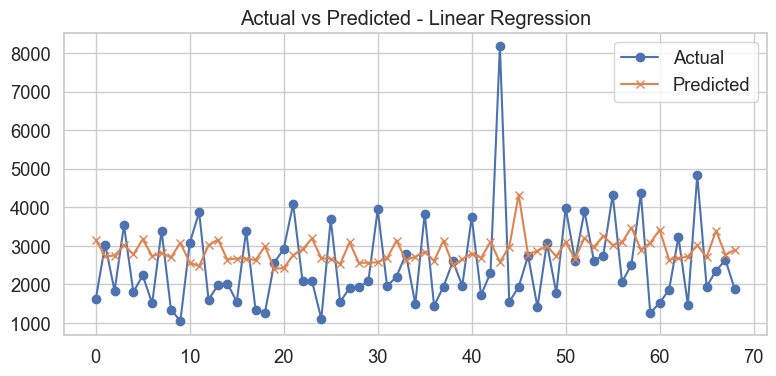


--- Random Forest Results: ---
MAE: 979.1845555555559
RMSE: 1718613.2980336295
R2: -0.2958291812067866


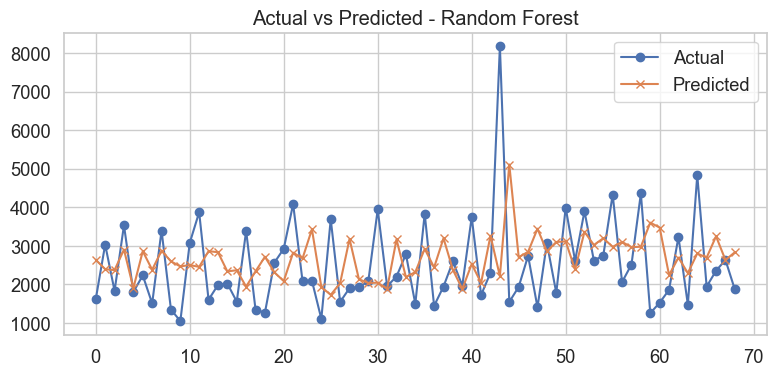


--- XGBoost Results: ---
MAE: 961.7652598505433
RMSE: 1688024.6618177483
R2: -0.27276544286191906


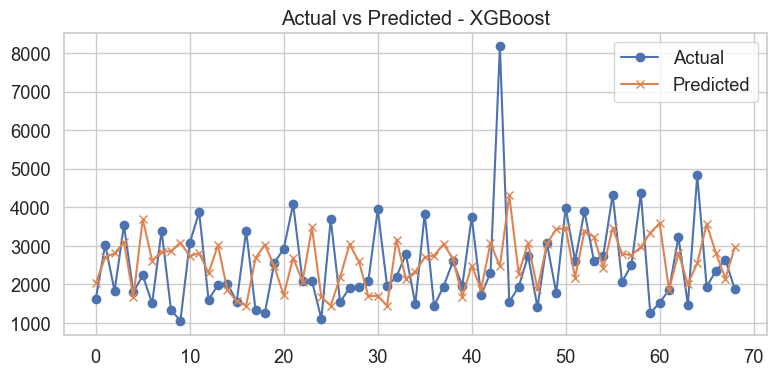

In [45]:
# --- Training & Evaluation ---
results = {}

for name, reg in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", reg)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    
    print(f"\n--- {name} Results: ---")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)

    # Plot Actual vs Predicted
    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label="Actual", marker="o")
    plt.plot(preds, label="Predicted", marker="x")
    plt.title(f"Actual vs Predicted - {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                           MAE          RMSE        R2
Linear Regression  1039.633111  1.635145e+06 -0.232894
Random Forest       979.184556  1.718613e+06 -0.295829
XGBoost             961.765260  1.688025e+06 -0.272765


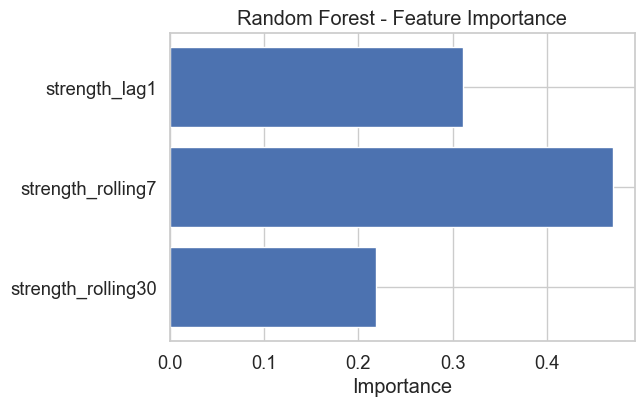

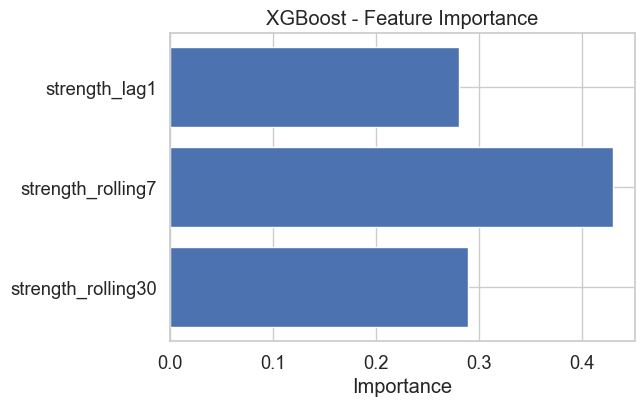

In [47]:
# --- Random Forest Feature Importance ---
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

rf_importances = rf_model.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(X.columns, rf_importances)
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# --- XGBoost Feature Importance ---
xgb_model = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)

xgb_importances = xgb_model.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(X.columns, xgb_importances)
plt.title("XGBoost - Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

#### 6. Feature Importance & Interpretation

1. **Random Forest**:
    1. `strength_rolling7` = most important predictor (~0.45).
    2. `strength_lag1` = secondary (~0.30).
    3. `strength_rolling30` = smaller but meaningful (~0.22).
2. **XGBoost**:
    1. `strength_rolling7` again strongest (~0.40).
    2. `strength_lag1` and `strength_rolling30` ~0.28 each.

### 7. Insights:

1. **Short-term workload consistency matters most:**
    1. Both Random Forest and XGBoost ranked the **7-day rolling volume** as the strongest predictor of next-day strength performance.
    2. This suggests that how much you lifted across the past week is more influential than a single session.
2. **Single-day effort contributes but isn’t dominant:**
    1. Yesterday’s training load (`lag1`) was less predictive than the rolling 7-day average.
    2. Performance depends on accumulated fatigue/adaptation, not just one hard day.
3. **Long-term trends play a smaller but steady role:**
    1. The 30-day rolling average had the lowest importance, but still showed that long-term training volume influences overall capacity.
    2. This matches the idea of chronic adaptation in exercise science.
4. **Models struggled to predict absolute values:**
    1. Metrics (negative R² across all models) indicate that load alone is insufficient to predict exact next-day strength.
    2. Other missing factors (muscle group splits, recovery days, sleep, nutrition, fatigue) likely play a critical role.

#### 7. Conclusion:
1. While the models had limited predictive accuracy, they revealed valuable insights into training dynamics:
    1. Consistency over the past week is the best predictor of performance.
    2. Single-day spikes have less influence than the broader training trend.
    3. Long-term volume shapes adaptation, but less directly than the weekly cycle.

### Phase 3 – Exploratory Training Load Visualization  

We attempted to unify strength and cardio into a single **total training load** metric.  
While predictive modeling was not successful (R² < 0), the visualization still provided meaningful insights:  

- **Daily load** is highly volatile **(blue)**.  
- The **7-day average (red)** highlights short-term training cycles.  
- The **30-day average (green)** shows long-term adaptation trends (peaks, deloads, ramp-ups).  

 **Insight:** Even though Phase 3 models did not generalize well, this analysis demonstrated the challenge of combining different training modalities and confirmed the importance of smoothing (rolling averages) to reveal training patterns.

![IMG](training_load.png)